# Import Libraries

In [68]:
# pip install geopandas
# pip install geopy
# pip install countryinfo
# pip install ratelimit

In [69]:
import http.client
import urllib.request
import urllib.parse
import urllib.error
import base64
import requests
import json
import io
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
import statsmodels.api as sm
import warnings
import scipy
from countryinfo import CountryInfo
from statsmodels.formula.api import glm, ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import Data
Data is sourced from the website https://stats.wto.org/ to analyze the annual global merchandise exports of 50 countries across a span of ten years, specifically from 1994 to 2014. The examination focuses on three product categories, including Manufactures, Fuels and Mining Products, and Agriculture Products.

In [70]:
headers = {
    # Request headers
    'Ocp-Apim-Subscription-Key': 'fd9c1a314e024089976f514cc887bc08',
}

params = urllib.parse.urlencode({
    # Request parameters
    'i': 'all',
    'name': '{string}',
    't': 'all',
    'pc': 'all',
    'tp': 'all',
    'frq': 'A',
    'lang': '1',
})

# Data must be imported from six APIs, each representing a product group for 25 countries, due to a 500-row limitation per API link
APIs = ['https://api.wto.org/timeseries/v1/data?i=ITS_MTV_AX&r=012,051,036,040,048,056,100,124,156,203,208,818,246,250,276,300,348,352,356,360,364,372,376,380,392&p=000&pc=MA&ps=1994-2014&subscription-key=fd9c1a314e024089976f514cc887bc08',
     'https://api.wto.org/timeseries/v1/data?i=ITS_MTV_AX&r=012,051,036,040,048,056,100,124,156,203,208,818,246,250,276,300,348,352,356,360,364,372,376,380,392&p=000&pc=MI&ps=1994-2014&subscription-key=fd9c1a314e024089976f514cc887bc08',
      'https://api.wto.org/timeseries/v1/data?i=ITS_MTV_AX&r=012,051,036,040,048,056,100,124,156,203,208,818,246,250,276,300,348,352,356,360,364,372,376,380,392&p=000&pc=AG&ps=1994-2014&subscription-key=fd9c1a314e024089976f514cc887bc08',
       'https://api.wto.org/timeseries/v1/data?i=ITS_MTV_AX&r=410,418,458,484,554,578,608,616,620,634,642,643,682,702,710,724,752,756,158,764,792,784,826,840,704&p=000&pc=MA&ps=1994-2014&subscription-key=fd9c1a314e024089976f514cc887bc08',
     'https://api.wto.org/timeseries/v1/data?i=ITS_MTV_AX&r=410,418,458,484,554,578,608,616,620,634,642,643,682,702,710,724,752,756,158,764,792,784,826,840,704&p=000&pc=MI&ps=1994-2014&subscription-key=fd9c1a314e024089976f514cc887bc08',
      'https://api.wto.org/timeseries/v1/data?i=ITS_MTV_AX&r=410,418,458,484,554,578,608,616,620,634,642,643,682,702,710,724,752,756,158,764,792,784,826,840,704&p=000&pc=AG&ps=1994-2014&subscription-key=fd9c1a314e024089976f514cc887bc08']

# Create "dfs" dictionary to include all dataframes
dfs = {}
sectors = {0:'MA1',1:'MI1',2:'AG1', 3:'MA2',4:'MI2',5:'AG2'} # MA: Manufactures; MI: Fuels and Mining Products; AG: Agriculture Products.

try:
    for link, name in zip(APIs, sectors):
        conn = http.client.HTTPSConnection('api.wto.org')
        conn.request("GET", link)
        response = conn.getresponse()
        data = response.read()
        conn.close()

        data_string = data.decode('ISO-8859-1')
        data_dict = json.loads(data_string)


        data_records = data_dict["Dataset"]
        
        
        df_name = f"df{sectors[name]}"
        dfs[df_name] = pd.DataFrame.from_records(data_records, index=range(len(data_records)))
        
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))
    

# Display all columns
pd.set_option('display.max_columns', None)  
dfs['dfMA1'].head()

# Export to excel
# df.to_excel('~/Downloads/testExcel.xlsx', index=False)


,IndicatorCategoryCode,IndicatorCategory,IndicatorCode,Indicator,ReportingEconomyCode,ReportingEconomy,PartnerEconomyCode,PartnerEconomy,ProductOrSectorClassificationCode,ProductOrSectorClassification,ProductOrSectorCode,ProductOrSector,PeriodCode,Period,FrequencyCode,Frequency,UnitCode,Unit,Year,ValueFlagCode,ValueFlag,TextValue,Value
0,ITS_MTV,Merchandise trade values,ITS_MTV_AX,Merchandise exports by product group  annual,276,Germany,000,World,SITC3,Merchandise - SITC Revision 3 (aggregates),MA,Manufactures,A,Annual,A,Annual,USM,Million US dollar,1994,None,None,None,339707.0
1,ITS_MTV,Merchandise trade values,ITS_MTV_AX,Merchandise exports by product group  annual,300,Greece,000,World,SITC3,Merchandise - SITC Revision 3 (aggregates),MA,Manufactures,A,Annual,A,Annual,USM,Million US dollar,1994,None,None,None,4302.0
2,ITS_MTV,Merchandise trade values,ITS_MTV_AX,Merchandise exports by product group  annual,348,Hungary,000,World,SITC3,Merchandise - SITC Revision 3 (aggregates),MA,Manufactures,A,Annual,A,Annual,USM,Million US dollar,1994,None,None,None,7338.0
3,ITS_MTV,Merchandise trade values,ITS_MTV_AX,Merchandise exports by product group  annual,352,Iceland,000,World,SITC3,Merchandise - SITC Revision 3 (aggregates),MA,Manufactures,A,Annual,A,Annual,USM,Million US dollar,1994,None,None,None,150.0
4,ITS_MTV,Merchandise trade values,ITS_MTV_AX,Merchandise exports by product group  annual,356,India,000,World,SITC3,Merchandise - SITC Revision 3 (aggregates),MA,Manufactures,A,Annual,A,Annual,USM,Million US dollar,1994,None,None,None,19985.0


# Data Processing

In [71]:
# Concatenate all dataframes into one
df_all = pd.concat([dfs['dfMA1'], dfs['dfMI1'], dfs['dfAG1'], dfs['dfMA2'], dfs['dfMI2'], dfs['dfAG2']], ignore_index=True)

# Narrow down to four columns
df_all = df_all[['ReportingEconomy', 'ProductOrSector', 'Year', 'Value']].sort_values(by=['ReportingEconomy', 'Year'])

pd.set_option('display.max_rows', None)  

print(len(df_all))
df_all.head()

3000


,ReportingEconomy,ProductOrSector,Year,Value
30,Algeria,Manufactures,1994,194.0
500,Algeria,Fuels and mining products,1994,8649.0
1000,Algeria,Agricultural products,1994,38.0
11,Algeria,Manufactures,1995,311.0
515,Algeria,Fuels and mining products,1995,9803.0


# First Analysis: 
Our initial focus involves exploring data across 50 countries from 1994 to 2014. We'll assess the relative contribution of three sectors and identify the dominant one in each country. The aim is to uncover patterns that could inform hypotheses about factors impacting economic growth.

In [72]:
# Group by using three columns as index: ReportingEconomy, ProductOrSector, and Year
df_gby = df_all.groupby(['ReportingEconomy','ProductOrSector','Year']).agg({'Value':'sum'}) # aggregating creates multi-index

# Calculate the percent value of each sector from each year, i.e. 
df_percent = df_gby.groupby(level=[0,2]).apply(lambda x: round(100*x/float(x.sum()),3)).reset_index() # Break multi-index into regular columns

# Rename columns
df_percent.rename(columns={'ReportingEconomy':'Country','ProductOrSector':'Sector','Value': 'Percent Value'}, inplace=True)

df_percent.head()

,Country,Sector,Year,Percent Value
0,Algeria,Agricultural products,1994,0.428
1,Algeria,Agricultural products,1995,1.230
2,Algeria,Agricultural products,1996,1.082
3,Algeria,Agricultural products,1997,0.317
4,Algeria,Agricultural products,1998,0.431


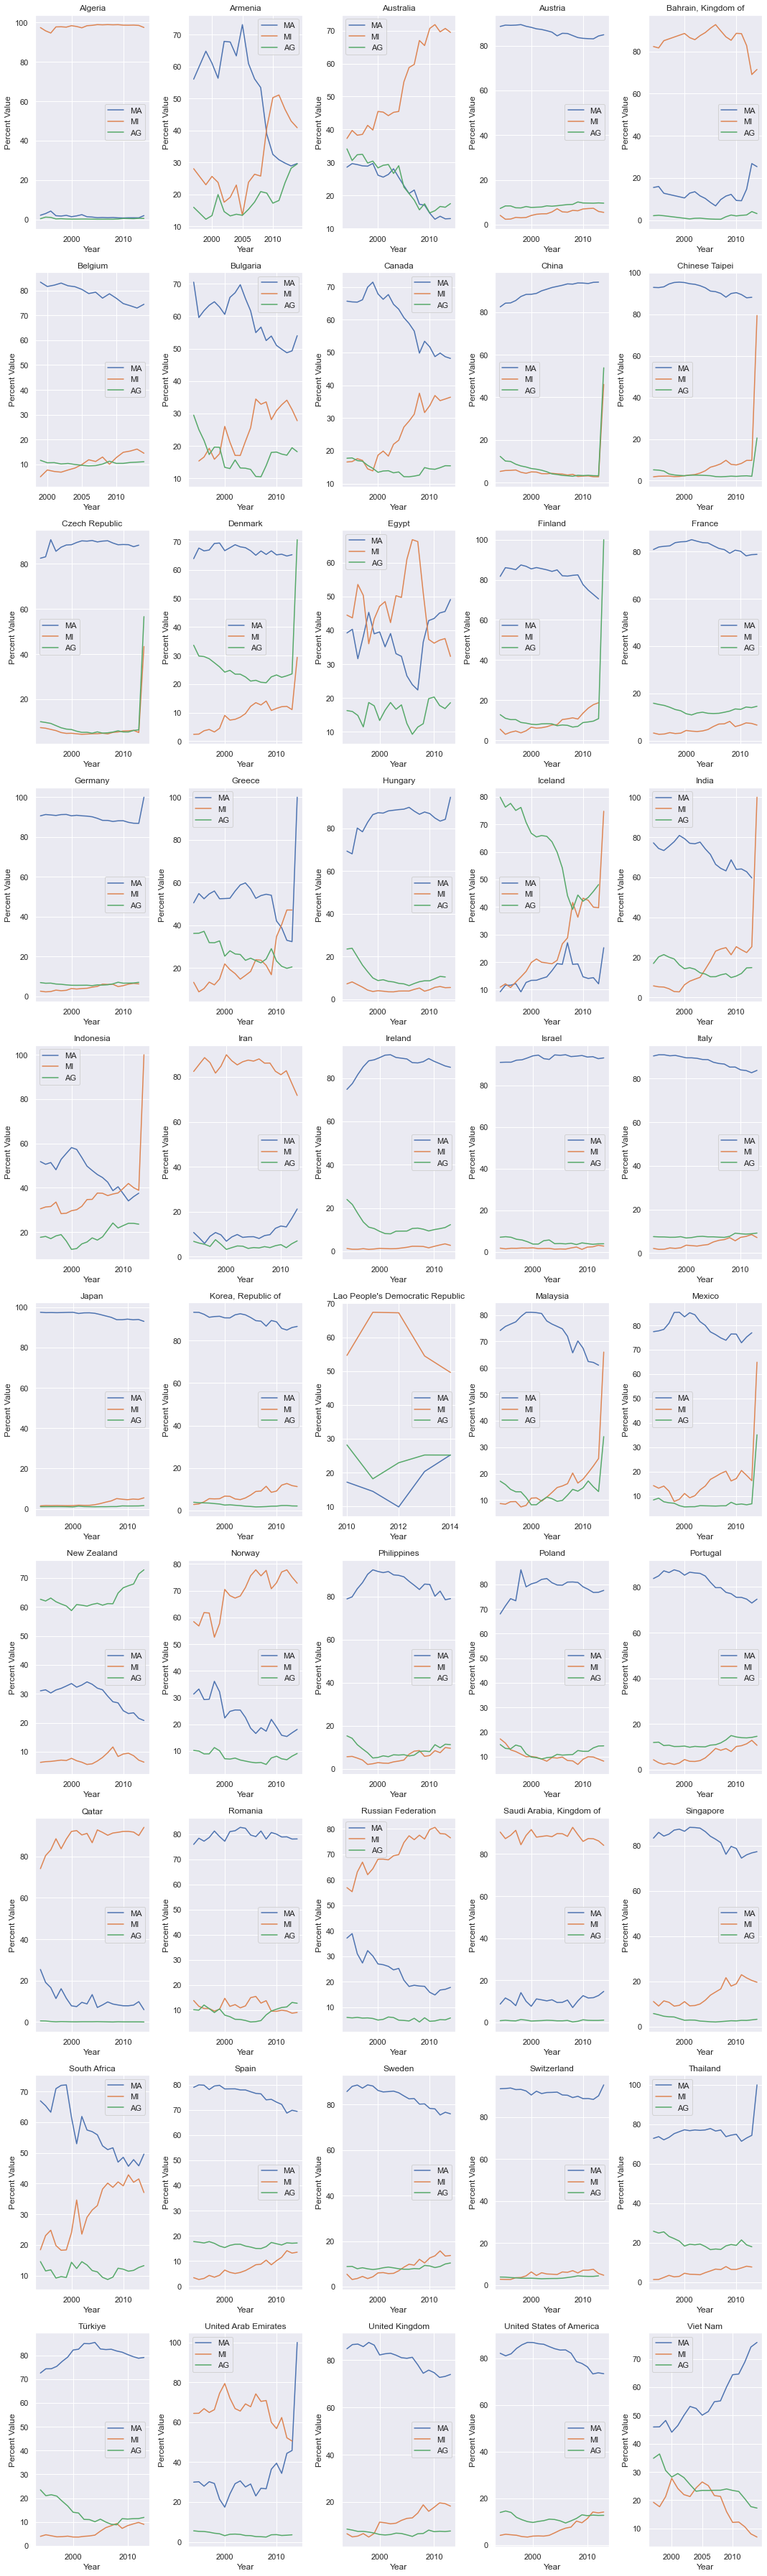

In [73]:
# Visualize trend lines for each country sector over years, each graph represents one country

# List of unique countries in the DataFrame
countries = df_percent['Country'].unique()

# Calculate the number of rows and columns for subplots
num_countries = len(countries)
num_rows = (num_countries - 1) // 5 + 1
num_cols = min(num_countries, 5)

# Set up the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Loop through each country and create the line graph
for i, country in enumerate(countries):
    # Filter data for the current country
    country_data = df_percent[df_percent['Country'] == country]
    
    # Extract data for each sector
    MA = country_data[country_data['Sector'] == 'Manufactures']
    MI = country_data[country_data['Sector'] == 'Fuels and mining products']
    AG = country_data[country_data['Sector'] == 'Agricultural products']
    
    # Plot three lines for each sector
    ax = axs[i // num_cols, i % num_cols]
    ax.plot(MA['Year'], MA['Percent Value'], label='MA')
    ax.plot(MI['Year'], MI['Percent Value'], label='MI')
    ax.plot(AG['Year'], AG['Percent Value'], label='AG')
    
    # Add labels, title, and legend for each plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Percent Value')
    ax.set_title(f'{country}')
    ax.legend()

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plots
plt.show()


Observations:
- There is one dominant export sector accounting for over half of the total percent value in most countries
- Many countries either have Manufactures or Fuels & Mining Products as their leading sector
- These patterns generally remain stable over time, except for certain countries such as Armenia, Egypt, or Greece

Next, we will create a geographical map, where each country is represented by a dot. The color of each dot will indicate the industry that has the highest average value over the 20-year period.

In [74]:
# Group by using two columns as index
df_gby_2 = df_all.groupby(['ReportingEconomy','ProductOrSector']).agg({'Value':'mean'}).reset_index() # aggregating creates multi-index, use reset_index() to reset it

# Return the highest value from a sector in each country
df_max = df_gby_2.groupby(['ReportingEconomy'])['Value'].max().to_frame()

# Filter df_gby_2 so that it includes the sector column
filtered_df = df_gby_2[df_gby_2['Value'].isin(df_max['Value'])].sort_values(by='Value', ascending = False).reset_index(drop=True)

filtered_df.head()


,ReportingEconomy,ProductOrSector,Value
0,Germany,Manufactures,800081.714286
1,China,Manufactures,748308.700000
2,United States of America,Manufactures,701394.000000
3,Japan,Manufactures,511863.650000
4,France,Manufactures,340449.500000


It is observed that the majority of countries have their dominant sector as Manufactures while a few other countries are dominated by Fuels and mining products.

In [75]:
# Replace country names so that they are recognizable by CountryInfo
rename_df = filtered_df.copy().replace({'ReportingEconomy':{'Bahrain, Kingdom of':'Bahrain', 
                                                            'Chinese Taipei':'Taiwan',
                                                            'Korea, Republic of':'South Korea',
                                                            'Saudi Arabia, Kingdom of':'Saudi Arabia',
                                                            'Türkiye':'Turkey',
                                                            'Viet Nam':'Vietnam'
                                                           }})

latitude = []
longitude = []

# Append latitudes and longitudes to two lists
for i in rename_df['ReportingEconomy']:
    listx = CountryInfo(i).capital_latlng()
    latitude.append(listx[0])
    longitude.append(listx[1])

rename_df['Latitude'] = latitude
rename_df['Longitude'] = longitude

rename_df = rename_df.reset_index(drop=True)

rename_df.head()

,ReportingEconomy,ProductOrSector,Value,Latitude,Longitude
0,Germany,Manufactures,800081.714286,52.517036,13.388860
1,China,Manufactures,748308.700000,39.906217,116.391276
2,United States of America,Manufactures,701394.000000,38.894986,-77.036571
3,Japan,Manufactures,511863.650000,35.682839,139.759455
4,France,Manufactures,340449.500000,48.856697,2.351462


In [76]:
fig = px.scatter_geo(rename_df,
                     lat='Latitude',
                     lon='Longitude',
                     color='ProductOrSector',
                     color_discrete_map={'Manufactures': 'green', 'Fuels and mining products': 'blue', 'Agricultural products': 'orange'},
                     hover_name='ReportingEconomy',
                     size='Value',
                     title='Dominant Export Category by Countries',
                     size_max=40)

fig.show()

Following our analysis, we will randomly choose 10 countries for further investigation in the second part, with most of them featuring manufacturing as their dominant industry. The process of choosing them will be further discussed below.

# Second Analysis:
In the initial assessment, the data indicates that the Manufactures sector constitutes a substantial proportion of total exports in the majority of countries under analysis (36 out of 50 countries). Consequently, our next analysis will center on the Manufactures sector, aiming to discern the key drivers behind its prevalent position and its growth over time.

In [77]:
# View list of series names
# more info: http://www.bd-econ.com/imfapi1.html

root = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/' # Root url
key_dataflow = 'Dataflow'  # return dataset/series names
series_list = requests.get(f'{root}{key_dataflow}').json()\
            ['Structure']['Dataflows']['Dataflow']

for series in series_list:
    print(f"{series['Name']['#text']}: {series['KeyFamilyRef']['KeyFamilyID']}")

Balance of Payments (BOP), 2017 M06: BOP_2017M06
Balance of Payments (BOP), 2020 M03: BOP_2020M3
Balance of Payments (BOP), 2017 M11: BOP_2017M11
Direction of Trade Statistics (DOTS), 2020 Q1: DOT_2020Q1
Government Finance Statistics Yearbook (GFSY 2016), Main Aggregates and Balances: GFSMAB2016
Balance of Payments (BOP), 2019 M12: BOP_2019M12
Government Finance Statistics Yearbook (GFSY 2014), Financial Assets and Liabilities by Counterpart Sector: GFSYFALCS2014
Government Finance Statistics Yearbook (GFSY 2016), Expense: GFSE2016
Fiscal Monitor (FM) October 2015: FM201510
Government Finance Statistics Yearbook (GFSY 2016), Integrated Balance Sheet (Stock Positions and Flows in Assets and Liabilities): GFSIBS2016
International Financial Statistics (IFS), 2019 M01: IFS_2019M01
Direction of Trade Statistics (DOTS), 2018 Q3: DOT_2018Q3
Fiscal Monitor (FM) April 2016: FM201604
Western Hemisphere Regional Economic Outlook (WHDREO) April 2015: WHDREO201504
Direction of Trade Statistics (DOT

We will rely on IMF as our data source to identify the key dimensions or datasets that significantly impact export activities. Our analysis will primarily focus on two main indicators: Export Quality (EQ) and Export Diversification (ED). As these two indicators encompass data spanning from 1976 to 2014, we will limit our selection to countries with data available for a period of 20 years, specifically from 1994 to 2014.

In [100]:
# Create a DataFrame with countries that have 'Manufactures' data in 1994
year_1994 = df_percent[(df_percent['Year'] == 1994) & (df_percent['Sector'] == 'Manufactures')]

# Create a DataFrame with countries that have 'Manufactures' data in 2014
year_2014 = df_percent[(df_percent['Year'].isin([2013,2014])) & (df_percent['Sector'] == 'Manufactures')]

# Find the intersection of countries in both DataFrames
countries_both_years = pd.merge(year_1994, year_2014, on='Country', how='inner')

# Filter by countries with manufactures as dominant sector
top = filtered_df[filtered_df['ProductOrSector']=='Manufactures']
top_lst = top['ReportingEconomy'].unique()
countries_both_years_ma = countries_both_years[countries_both_years['Country'].isin(top_lst)]

print('Countries with sufficient data:', countries_both_years_ma['Country'].unique())

Countries with sufficient data: ['Austria' 'Bulgaria' 'Canada' 'China' 'Chinese Taipei' 'Czech Republic'
 'Denmark' 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'India'
 'Indonesia' 'Ireland' 'Israel' 'Italy' 'Japan' 'Korea, Republic of'
 'Malaysia' 'Mexico' 'Philippines' 'Poland' 'Portugal' 'Romania'
 'Singapore' 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Thailand'
 'Türkiye' 'United Kingdom' 'United States of America']


In [79]:
# View dimensions of series
key_dimensions = []
dimension_lists = []

def dimension_search(names):
    for name in names:
        key_dimensions.append(f'DataStructure/{name}')
        
        dimension_data = requests.get(f'{root}{key_dimensions[-1]}').json()
        dimension_list = dimension_data['Structure']['KeyFamilies']['KeyFamily']\
                    ['Components']['Dimension']

        dimension_lists.append(dimension_list)
        
        for n, dimension in enumerate(dimension_list):
            print(f'Dimension {n+1} for {name}: {dimension["@codelist"]}')
            
        print('\n')

dimension_search(['ED', 'EQ'])

Dimension 1 for ED: CL_FREQ
Dimension 2 for ED: CL_AREA_ED
Dimension 3 for ED: CL_INDICATOR_ED


Dimension 1 for EQ: CL_FREQ
Dimension 2 for EQ: CL_AREA_EQ
Dimension 3 for EQ: CL_PRODUCT_EQ
Dimension 4 for EQ: CL_INDICATOR_EQ




Dimension abbreviations: 1) Frequency 2) Referenced country/area 3) Indicators within this key_dimension

In [80]:
# Find country codes
country_list = countries_both_years_ma['Country'].unique()
country_code_list = dict()

for dimension_list in dimension_lists:
    CodeList_Area = f"CodeList/{dimension_list[1]['@codelist']}"
    dimension_data = requests.get(f'{root}{CodeList_Area}').json()
    country_df = pd.DataFrame(dimension_data['Structure']['CodeLists']['CodeList']['Code'])
    
    # Filter codes based on country_list
    filtered_codes = country_df[country_df['Description'].apply(lambda x: x.get('#text', None) in country_list)]

# Match each code list to the country name
for index, row in filtered_codes.iterrows():
    country_code_list[row['@value']] = row['Description']['#text']
    
print(country_code_list)

{'AT': 'Austria', 'BG': 'Bulgaria', 'CA': 'Canada', 'CN': 'China', 'CZ': 'Czech Republic', 'DK': 'Denmark', 'FI': 'Finland', 'FR': 'France', 'DE': 'Germany', 'GR': 'Greece', 'HU': 'Hungary', 'IN': 'India', 'ID': 'Indonesia', 'IE': 'Ireland', 'IL': 'Israel', 'IT': 'Italy', 'JP': 'Japan', 'KR': 'Korea, Republic of', 'MY': 'Malaysia', 'MX': 'Mexico', 'PH': 'Philippines', 'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania', 'SG': 'Singapore', 'ZA': 'South Africa', 'ES': 'Spain', 'SE': 'Sweden', 'CH': 'Switzerland', 'TH': 'Thailand', 'GB': 'United Kingdom'}


There are 34 countries that we are using for further analysis from the list above

In [81]:
# Find columns in dimensions for both indices:
def column_search(dimension_list):
    if f"CodeList/{dimension_list[2]['@codelist']}" == 'CodeList/CL_INDICATOR_ED':
        CodeList_Indicator = 'CodeList/CL_INDICATOR_ED'
    else:
        CodeList_Indicator = 'CodeList/CL_INDICATOR_EQ'
    
    column_list = requests.get(f'{root}{CodeList_Indicator}').json()\
                ['Structure']['CodeLists']['CodeList']['Code']
    for column in column_list:
        print(f"{column['Description']['#text']}: {column['@value']}")
    print('\n')
        
for dimension_list in dimension_lists:
    column_search(dimension_list)
    

Export Diversification Index: total_theil
Extensive Margin: between_theil
Intensive Margin: within_theil


Average quality imported: qual_Mmean
Average unit values imported: uv_Mmean
Export quality 95 percent interval - lower bound: qual_LowerBound95
Export quality 95 percent interval - upper bound: qual_UpperBound95
Export Quality Index: qual
Exporter real gross domestic product per capita: Xgdppc
Trade value of exports: value
Unit value 95 percent interval - lower bound: uv_LowerBound95
Unit value 95 percent interval - upper bound: uv_UpperBound95
Unit value of exports: uv




For the EQ index, we will use "Export Quality Index: qual" and ED index, "Export Diversification Index: total_theil." The output will be a dictionary containing 10 dataframes, each consisting of 4 columns: Year, Export Diversification, Export Quality, Export Value

In [82]:
# Create a dictionary to store all EQs from 10 countries
merged_by_year = {}
startTime = time.time()

# Loop through each country code in country_code_list:
for code, name in country_code_list.items():
    while True:
        try:
            EQ_data = f'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/EQ/A.{code}.All_products.qual.?startPeriod=1994&endPeriod=2014'
            ED_data = f'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/ED/A.{code}.total_theil.?startPeriod=1994&endPeriod=2014'

            # Request EQ data
            EQ_request = requests.get(EQ_data).json()
            Export_Quality = pd.DataFrame(EQ_request['CompactData']['DataSet']['Series']['Obs'])

            # Request ED data
            ED_request = requests.get(ED_data).json()
            Export_Diver = pd.DataFrame(ED_request['CompactData']['DataSet']['Series']['Obs'])

            # Change @TIME_PERIOD type from object to int64 to merge
            Export_Quality['@TIME_PERIOD']=Export_Quality['@TIME_PERIOD'].astype(int)
            Export_Diver['@TIME_PERIOD']=Export_Diver['@TIME_PERIOD'].astype(int)

            # Filter export data by country
            Export_Value = df_all[(df_all['ReportingEconomy']==name)&(df_all['ProductOrSector']== 'Manufactures')][['Year','Value']]

            # Merge two dataframes by two year columns (EQ)
            merged_EQ = pd.merge(Export_Quality, Export_Value, left_on= '@TIME_PERIOD', right_on='Year').iloc[:, [0,1,3]]

            merged_EQ_rename = merged_EQ.rename({'@TIME_PERIOD':'Year', '@OBS_VALUE':'ExportQuality', 'Value':'ExportValue'}, axis='columns')

            # Merge two dataframes by two year columns (ED)
            merged_both = pd.merge(Export_Diver, merged_EQ_rename, left_on= '@TIME_PERIOD', right_on='Year').iloc[:, [0,1,3,4]]

            merged_both_rename = merged_both.rename({'@TIME_PERIOD':'Year', '@OBS_VALUE':'ExportDiversification'}, axis='columns')

            # Convert to numeric (float) data types
            merged_both_rename['ExportDiversification'] = pd.to_numeric(merged_both_rename['ExportDiversification'], errors='coerce')
            merged_both_rename['ExportQuality'] = pd.to_numeric(merged_both_rename['ExportQuality'], errors='coerce')
            # Name the data
            merged_name = f'{name}'

            # Include in dictionary
            merged_by_year[merged_name] = merged_both_rename
            
#             time.sleep(1)
        except:
            # Limit: 10 requests in 5 second window from one user (IP), aka 10s for 20 requests
            continue
        break

endTime = time.time()
elapsedTime = endTime - startTime
print("Elapsed Time = %s" % elapsedTime)


Elapsed Time = 36.07293391227722


In [83]:
merged_by_year.keys()

dict_keys(['Austria', 'Bulgaria', 'Canada', 'China', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea, Republic of', 'Malaysia', 'Mexico', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Singapore', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom'])

Now, we can start applying regression into the model using China as an example

    Year  ExportDiversification  ExportQuality  ExportValue
0   1994               2.017359       0.840865      99524.0
1   1995               1.949298       0.842678     125007.0
2   1996               1.994465       0.847296     127259.0
3   1997               1.987751       0.848989     155907.0
4   1998               2.019562       0.856390     160342.0
5   1999               2.030033       0.855546     172060.0
6   2000               2.015403       0.868787     219859.0
7   2001               2.014423       0.884378     235822.0
8   2002               2.033101       0.891809     292561.0
9   2003               2.064152       0.896155     396993.0
10  2004               2.068938       0.906254     542366.0
11  2005               2.072325       0.916901     700342.0
12  2006               2.054028       0.918741     895390.0
13  2007               1.900525       0.922928    1136143.0
14  2008               1.855889       0.919985    1331388.0
15  2009               1.981548       0.

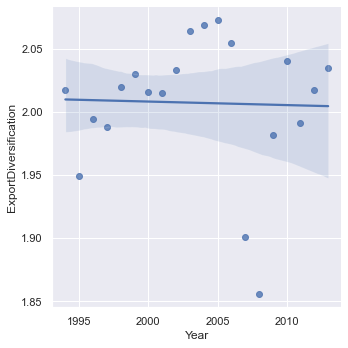

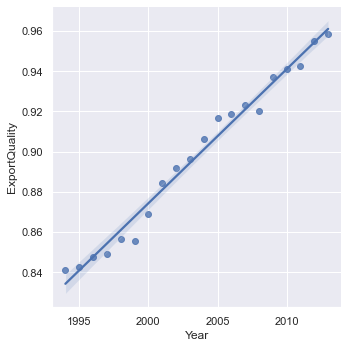

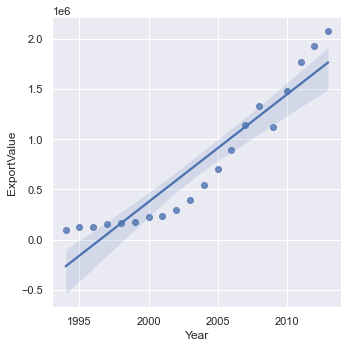

In [84]:
# Example to see the patterns
data = merged_by_year['China']
print(data)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lmplot(x='Year', y='ExportDiversification', data=data)
sns.lmplot(x='Year', y='ExportQuality', data=data)
sns.lmplot(x='Year', y='ExportValue', data=data)

plt.show()
plt.close()

In [85]:
# Prepare data to test ARIMA
series_data = data[['Year','ExportValue']]
series_data['Year'] = series_data['Year'].astype(str)

# Set index to year
series_data = series_data.set_index('Year')

# Test adfuller for stationarity
test_stationary = adfuller(series_data)
sig_level = 0.05

if test_stationary[1] > sig_level:
    print('Need to transform to stationary')
    
warnings.filterwarnings('ignore')

Need to transform to stationary


Next, we need to find the orders for the ARIMA

In [86]:
def find_orders(df):
    order_aic=[]

    # Test p, q, d variables to find the best combination with lowest AIC
    for p in range(2):
        for q in range(2):
            for d in range(2):
                model=ARIMA(df_log, order=(p,d,q))
                results=model.fit()

            order_aic.append((p,d,q,results.aic))

    order_df = pd.DataFrame(order_aic,columns=['p','d','q','AIC'])

    # Sort AIC values from lowest to highest and choose the top one in the list
    result = order_df.sort_values('AIC').iloc[0,:]
    p,d,q = result[0], result[1], result[2]
    
    return p,d,q

# Transform to stationary with log
df_log = np.log(series_data)

p,d,q = find_orders(df_log)


In [87]:
test = data
test['Year'] = test['Year'].astype(str)
test = test.set_index('Year')

# Transform to stationary
test['ExportValue'] = np.log(test['ExportValue'])
test = test.rename(columns={'ExportValue':'ExportValue_log'})

test.head()

,ExportDiversification,ExportQuality,ExportValue_log
Year,,,
1994,2.017359,0.840865,11.508154
1995,1.949298,0.842678,11.736125
1996,1.994465,0.847296,11.753980
1997,1.987751,0.848989,11.957015
1998,2.019562,0.856390,11.985064


In [88]:
def fit_sarimax(df,p,d,q):
    sarimax_model = SARIMAX(df['ExportValue_log'], order=(p,d,q), exog=df[['ExportDiversification', 'ExportQuality']])

    res = sarimax_model.fit(disp=False)
    
    summary = res.summary()
    p_ED = res.pvalues['ExportDiversification']
    p_EQ = res.pvalues['ExportQuality']    
    return summary, p_ED, p_EQ

print(fit_sarimax(test,p,d,q)[0],'\n')
print('p-value for ExportDiversification:', fit_sarimax(test,p,d,q)[1])
print('p-value for ExportQuality:', fit_sarimax(test,p,d,q)[2])

                               SARIMAX Results                                
Dep. Variable:        ExportValue_log   No. Observations:                   20
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  13.910
Date:                Wed, 08 Nov 2023   AIC                            -17.819
Time:                        21:39:57   BIC                            -13.097
Sample:                    01-01-1994   HQIC                           -17.020
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ExportDiversification    -1.0197      0.500     -2.040      0.041      -1.999      -0.040
ExportQuality            -1.8498      5.570     -0.332      0.740     -12.767       9.068
ar.L1   

In [95]:
data_to_append = []

for key, value in merged_by_year.items():
    # Prepare series to test ARIMA
    extract = value[['Year','ExportValue']]
    extract['Year'] = extract['Year'].astype(str)
    extract = extract.set_index('Year')

    # Find orders
    extract_log = np.log(extract)
    p,d,q = find_orders(extract_log)
    
    # Prepare the main dataset
    main = value
    main['Year'] = main['Year'].astype(str)
    main = main.set_index('Year')
    main['ExportValue'] = np.log(main['ExportValue'])
    main = main.rename(columns={'ExportValue':'ExportValue_log'})
    
    # Retrieve p-values from two exogeneous variables
    pval_ED = fit_sarimax(main,p,d,q)[1]
    pval_EQ = fit_sarimax(main,p,d,q)[2]
    
    # Append the values to the list
    data_to_append.append({'Country': key, 'ED p-value': pval_ED, 'EQ p-value': pval_EQ})

p_table = pd.DataFrame(data_to_append)

p_table

,Country,ED p-value,EQ p-value
0,Austria,5.783555e-01,0.031623
1,Bulgaria,4.660857e-01,0.761194
2,Canada,3.645617e-07,0.107622
3,China,4.136434e-02,0.739832
4,Czech Republic,4.004480e-01,0.161512
5,Denmark,1.545916e-02,0.045384
6,Finland,5.619313e-01,0.041233
7,France,9.576169e-01,0.007307
8,Germany,3.957787e-01,0.115101
9,Greece,2.836870e-01,0.000033


In [97]:
# Conduct meta-analysis of p-values from datasets from each countries
ED_sum = scipy.stats.combine_pvalues(p_table['ED p-value'], method='fisher', weights=None)
EQ_sum = scipy.stats.combine_pvalues(p_table['EQ p-value'], method='fisher', weights=None)

print(ED_sum[1]) 
print(EQ_sum[1])

6.551154628757119e-23
5.2122984236471744e-11


Since both ED and EQ have p-values lower than 0.05, we can reject the null hypothesis and prove that the two factors have direct influence on Export Value.